In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import Counter
from numpy.random import RandomState
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [2]:
raw_data = pd.read_csv("level_progress.csv")
raw_data.dtypes

event_datetime    object
player_id         object
level_number       int64
status            object
session_id        object
dtype: object

In [3]:
raw_data['event_datetime']= pd.to_datetime(raw_data['event_datetime'])
raw_data.dtypes

event_datetime    datetime64[ns]
player_id                 object
level_number               int64
status                    object
session_id                object
dtype: object

### Create Weekdays from date 0-Monday till 6-Sunday
### Create Day of month, Hour , Minute and Seconds of the events

In [4]:
raw_data['day_of_week_num'] = raw_data['event_datetime'].dt.dayofweek
raw_data['day_of_month'] = raw_data['event_datetime'].dt.day
raw_data['Hour'] = raw_data['event_datetime'].dt.hour
raw_data['Minute'] = raw_data['event_datetime'].dt.minute
raw_data['Seconds'] = raw_data['event_datetime'].dt.second

raw_data=raw_data.sort_values(['player_id','event_datetime','level_number'])
raw_data.head()

,event_datetime,player_id,level_number,status,session_id,day_of_week_num,day_of_month,Hour,Minute,Seconds
43025,2020-11-27 20:08:39.885,00001bc5552cd394a4b25b2ceb4ae7cd,0,complete,3d99b46e8e892eac3b40b673140a8c23,4,27,20,8,39
17922,2020-11-27 20:09:59.364,00001bc5552cd394a4b25b2ceb4ae7cd,1,start,3d99b46e8e892eac3b40b673140a8c23,4,27,20,9,59
43902,2020-11-27 20:11:37.082,00001bc5552cd394a4b25b2ceb4ae7cd,1,complete,3d99b46e8e892eac3b40b673140a8c23,4,27,20,11,37
23638,2020-11-27 20:12:22.874,00001bc5552cd394a4b25b2ceb4ae7cd,2,start,3d99b46e8e892eac3b40b673140a8c23,4,27,20,12,22
20172,2020-11-27 20:16:13.531,00001bc5552cd394a4b25b2ceb4ae7cd,2,complete,3d99b46e8e892eac3b40b673140a8c23,4,27,20,16,13


In [5]:
raw_data.describe()

,level_number,day_of_week_num,day_of_month,Hour,Minute,Seconds
count,55826.000000,55826.000000,55826.000000,55826.000000,55826.000000,55826.000000
mean,5.991778,3.197972,18.883800,14.580948,29.688944,29.394959
std,5.988455,2.099120,9.055974,5.620452,17.270525,17.332970
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,13.000000,11.000000,15.000000,14.000000
50%,4.000000,3.000000,22.000000,15.000000,30.000000,29.000000
75%,8.000000,5.000000,26.000000,19.000000,44.000000,44.000000
max,49.000000,6.000000,30.000000,23.000000,59.000000,59.000000


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55826 entries, 43025 to 8565
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   event_datetime   55826 non-null  datetime64[ns]
 1   player_id        55826 non-null  object        
 2   level_number     55826 non-null  int64         
 3   status           55826 non-null  object        
 4   session_id       55826 non-null  object        
 5   day_of_week_num  55826 non-null  int64         
 6   day_of_month     55826 non-null  int64         
 7   Hour             55826 non-null  int64         
 8   Minute           55826 non-null  int64         
 9   Seconds          55826 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 4.7+ MB


In [7]:
print("Total no of entries ===>>> " , len(raw_data))
print("Total no of levels started in entire dataset ===>>> ", len(raw_data.loc[raw_data['status'] == "start"]))
print("Total number of level completions in entire dataset===>>> ", len(raw_data.loc[raw_data['status'] == "complete"]))
print("Total no of levels failed in entire dataset ===>>> " , len(raw_data.loc[raw_data['status'] == "fail"]) )

Total no of entries ===>>>  55826
Total no of levels started in entire dataset ===>>>  31109
Total number of level completions in entire dataset===>>>  20571
Total no of levels failed in entire dataset ===>>>  4146


In [8]:
def mssing_levels(level_list): 
    return [x for x in range(level_list[0], level_list[-1]+1)  
                               if x not in level_list] 
  

raw_data_failure = raw_data.loc[raw_data['status'] == "fail"]

level_list = (sorted(raw_data_failure['level_number'].unique())) 
print("Levels where no failure was reported ===>>> " ,mssing_levels(level_list))

Levels where no failure was reported ===>>>  [34, 36, 40, 41, 43]


In [9]:
print("Total no of unique playes in the dataset ===>>> ", len(raw_data['player_id'].unique()))
print("Total no of unique playes in the dataset who failed at some level ===>>> ", len(raw_data_failure['player_id'].unique()))

Total no of unique playes in the dataset ===>>>  3872
Total no of unique playes in the dataset who failed at some level ===>>>  1561


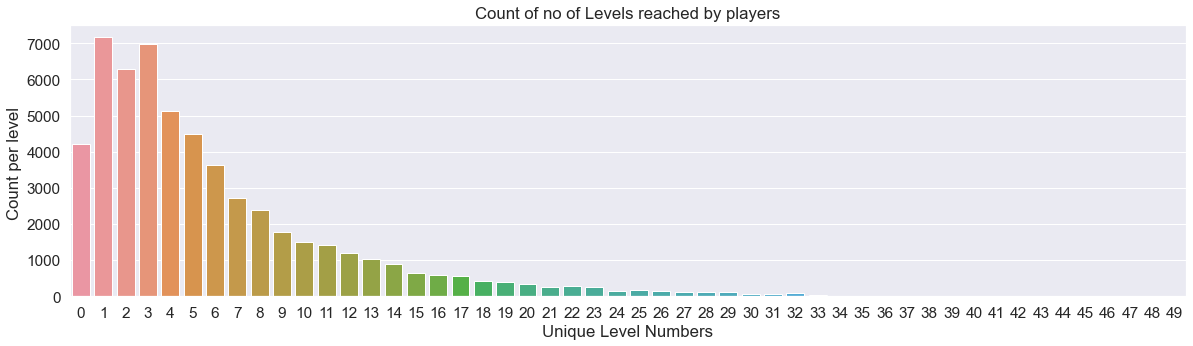

In [10]:
import seaborn as sns
plt.rcParams["figure.figsize"]=20,5
sns.set(font_scale=1.4) 

plot = sns.countplot(x="level_number", data=raw_data)    

plot.set(xlabel="Unique Level Numbers", ylabel = "Count per level ")
plot.set_title('Count of no of Levels reached by players')


plt.show()

### Pivot table to check the percentage of failure in each level_number

In [11]:
raw_data_failure_group=pd.DataFrame(raw_data_failure.groupby(['player_id','level_number'])['status'].count())
b= (raw_data_failure_group.pivot_table(values=['status'], index=['level_number'], aggfunc=[len]))
(100. * b / b.sum()).round(2).astype(str) + '%'

,len
,status
level_number,
0,1.1%
1,0.47%
2,2.61%
3,21.59%
4,12.01%
5,12.45%
6,9.52%
7,6.19%


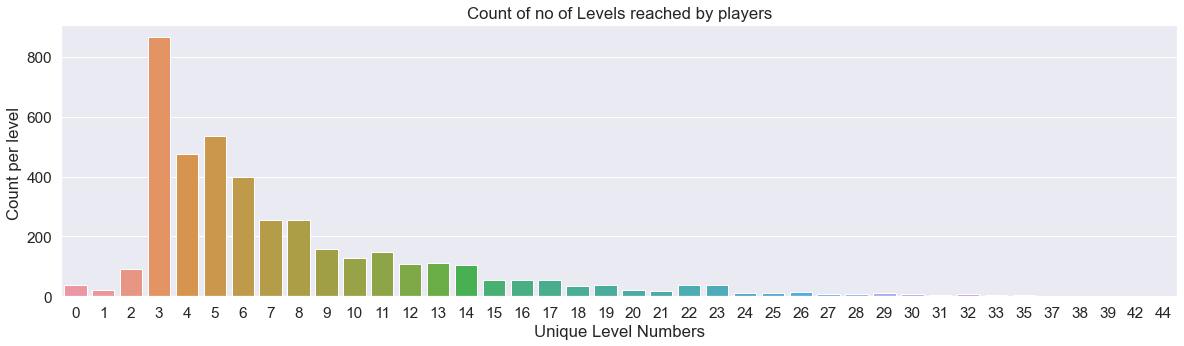

In [12]:
import seaborn as sns



plt.rcParams["figure.figsize"]=20,5
sns.set(font_scale=1.4) 

plot = sns.countplot(x="level_number", data=raw_data_failure)    

plot.set(xlabel="Unique Level Numbers", ylabel = "Count per level ")
plot.set_title('Count of no of Levels reached by players')


plt.show()

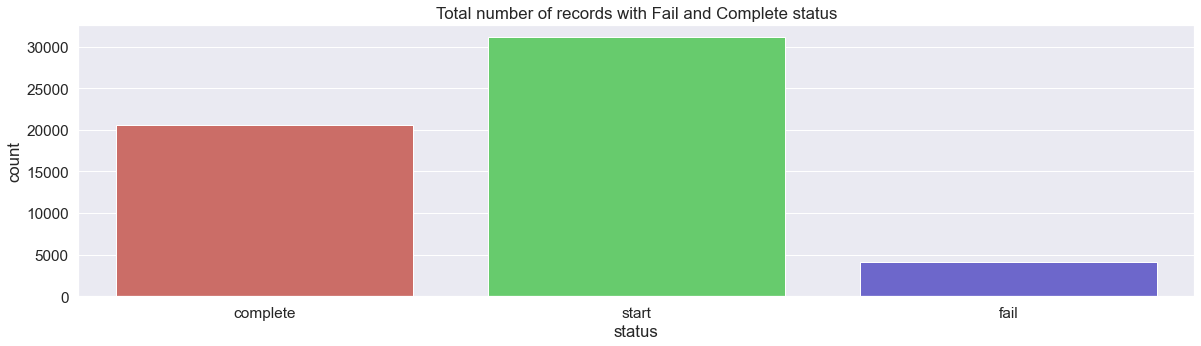

In [13]:

plot = sns.countplot(x='status',data=raw_data, palette='hls')
plot.set_title('Total number of records with Fail and Complete status')
# plot.set(xlabel="Unique Level Numbers", ylabel = "Count per level ")


plt.show()

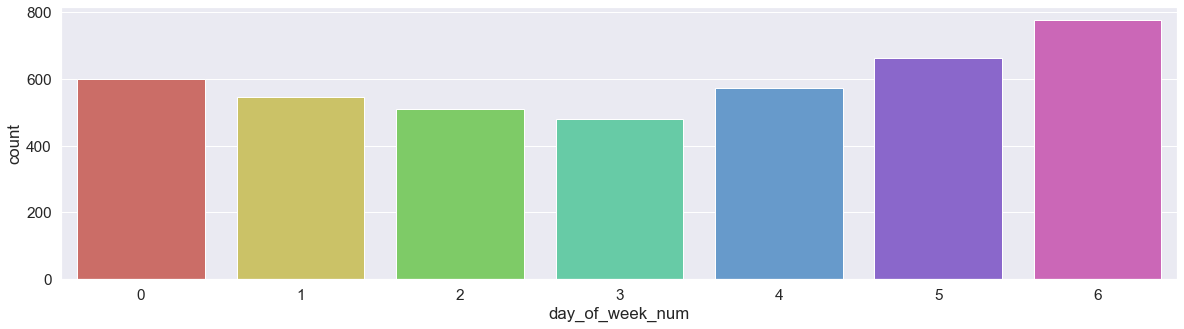

In [14]:
sns.countplot(x='day_of_week_num',data=raw_data_failure, palette='hls')
plt.show()

### Convert Status values : Start, Fail, Complete into Categorical Values = STart: 2, Fail: 1, Complete:0

In [15]:
dummy_column =  ['status']

def binary_map(x):
    return x.map({'fail': 1, "complete": 0, "start": 2})

raw_data[dummy_column] = raw_data[dummy_column].apply(binary_map)
raw_data = raw_data.loc[raw_data["status"] != 2 ]  # Remove start status

raw_data = raw_data.loc[raw_data["level_number"] !=0]  # Remove Level_number 0 - does not have start fail status

### One hot encoding does not allow prefixing column names so using dummy encoding to create Categorical Columns

### The raw_dataset will be preserved and all new changes will be done on a dataset named Processed_dataset

In [16]:

 
processed_dataset = raw_data.copy()

processed_dataset = processed_dataset.loc[processed_dataset["day_of_week_num"] != 6 ]  # Remove Sunday - reference class
processed_dataset = processed_dataset.loc[processed_dataset["level_number"] !=3]  # Remove Level_number 3 - reference class

level_number_df  = pd.DataFrame(processed_dataset["level_number"])
dum_df = pd.get_dummies(level_number_df, columns=["level_number"], prefix=["level_number"] )
processed_dataset = processed_dataset.join(dum_df)

 
day_of_week_num_df  = pd.DataFrame(processed_dataset["day_of_week_num"])
dum_df = pd.get_dummies(day_of_week_num_df, columns=["day_of_week_num"], prefix=["day_of_week_num"] )
processed_dataset = processed_dataset.join(dum_df)
processed_dataset.head()

,event_datetime,player_id,level_number,status,session_id,day_of_week_num,day_of_month,Hour,Minute,Seconds,...,level_number_45,level_number_46,level_number_47,level_number_48,day_of_week_num_0,day_of_week_num_1,day_of_week_num_2,day_of_week_num_3,day_of_week_num_4,day_of_week_num_5
43902,2020-11-27 20:11:37.082,00001bc5552cd394a4b25b2ceb4ae7cd,1,0,3d99b46e8e892eac3b40b673140a8c23,4,27,20,11,37,...,0,0,0,0,0,0,0,0,1,0
20172,2020-11-27 20:16:13.531,00001bc5552cd394a4b25b2ceb4ae7cd,2,0,3d99b46e8e892eac3b40b673140a8c23,4,27,20,16,13,...,0,0,0,0,0,0,0,0,1,0
48633,2020-11-18 17:51:00.223,000026e096ee1c36cb88234a4dcbb42e,1,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,51,0,...,0,0,0,0,0,0,1,0,0,0
47716,2020-11-18 17:53:56.799,000026e096ee1c36cb88234a4dcbb42e,2,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,53,56,...,0,0,0,0,0,0,1,0,0,0
50674,2020-11-18 17:57:08.119,000026e096ee1c36cb88234a4dcbb42e,4,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,57,8,...,0,0,0,0,0,0,1,0,0,0


In [17]:
processed_dataset.columns

Index(['event_datetime', 'player_id', 'level_number', 'status', 'session_id',
       'day_of_week_num', 'day_of_month', 'Hour', 'Minute', 'Seconds',
       'level_number_1', 'level_number_2', 'level_number_4', 'level_number_5',
       'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9',
       'level_number_10', 'level_number_11', 'level_number_12',
       'level_number_13', 'level_number_14', 'level_number_15',
       'level_number_16', 'level_number_17', 'level_number_18',
       'level_number_19', 'level_number_20', 'level_number_21',
       'level_number_22', 'level_number_23', 'level_number_24',
       'level_number_25', 'level_number_26', 'level_number_27',
       'level_number_28', 'level_number_29', 'level_number_30',
       'level_number_31', 'level_number_32', 'level_number_33',
       'level_number_34', 'level_number_35', 'level_number_36',
       'level_number_37', 'level_number_38', 'level_number_39',
       'level_number_40', 'level_number_41', 'level_n

### Model-1  with only 47 levels as categorical variables with Level 3 being the reference class and level 0 & 49 are excluded with no fail or complete status

In [18]:
X= processed_dataset[[ 'level_number_1', 'level_number_2',   'level_number_4', 'level_number_5', 'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9', 'level_number_10', 'level_number_11', 'level_number_12', 'level_number_13', 'level_number_14', 'level_number_15', 'level_number_16', 'level_number_17', 'level_number_18', 'level_number_19', 'level_number_20', 'level_number_21', 'level_number_22', 'level_number_23', 'level_number_24', 'level_number_25', 'level_number_26', 'level_number_27', 'level_number_28', 'level_number_29', 'level_number_30', 'level_number_31', 'level_number_32', 'level_number_33', 'level_number_34', 'level_number_35', 'level_number_36', 'level_number_37', 'level_number_38', 'level_number_39', 'level_number_40', 'level_number_41', 'level_number_42', 'level_number_43', 'level_number_44', 'level_number_45', 'level_number_46', 'level_number_47', 'level_number_48']].copy()
y= pd.DataFrame(processed_dataset["status"])
 

# Stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

# Logistic regression model
logm_stratify = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm_stratify.fit(maxiter=5000).summary()

C:\Users\mashv\.conda\envs\Kwalee\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\mashv\.conda\envs\Kwalee\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\mashv\.conda\envs\Kwalee\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\mashv\.conda\envs\Kwalee\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\mashv\.conda\envs\Kwalee\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\mashv\.conda\envs\Kwalee\lib\site-packages\sta

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                10261
Model:                            GLM   Df Residuals:                    10261
Model Family:                Binomial   Df Model:                           -1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 07 Jan 2021   Deviance:                          nan
Time:                        10:59:55   Pearson chi2:                 1.19e+19
No. Iterations:                  5000                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.338e+27    3.4e+19  -3.93e+07      0.000   -1.34e+27   -1.34e+27
level_number_1   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_2   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_4   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_5   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_6   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_7   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_8   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_9   1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_10  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_11  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_12  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_13  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_14  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_15  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_16  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_17  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_18  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_19  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_20  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_21  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_22  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_23  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_24  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_25  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_26  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_27  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_28  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_29  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_30  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_31  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_32  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_33  1.338e+27    3.4e+19   3.93e+07      0.000    1.34e+27    1.34e+27
level_number_34  1.338e+27    3.4e+19   3.93e+07      0.000

### Model-2, with only 28 levels as categorical variables with Level 3 being the reference class and level 30-48 are excluded because of less data

In [19]:
X= processed_dataset[[  'level_number_1', 'level_number_2',   'level_number_4', 'level_number_5', 'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9', 'level_number_10', 'level_number_11', 'level_number_12', 'level_number_13', 'level_number_14', 'level_number_15', 'level_number_16', 'level_number_17', 'level_number_18', 'level_number_19', 'level_number_20', 'level_number_21', 'level_number_22', 'level_number_23', 'level_number_24', 'level_number_25', 'level_number_26', 'level_number_27', 'level_number_28', 'level_number_29']].copy()

y= pd.DataFrame(processed_dataset["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

# Logistic regression model
logm_stratify = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm_stratify.fit(maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                10261
Model:                            GLM   Df Residuals:                    10232
Model Family:                Binomial   Df Model:                           28
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4226.1
Date:                Thu, 07 Jan 2021   Deviance:                       8452.2
Time:                        10:59:56   Pearson chi2:                 1.03e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0664      0.253     -4.215      0.000      -1.562      -0.570
level_number_1     -4.2061      0.419    -10.035      0.000      -5.028      -3.385
level_number_2     -2.2261      0.288     -7.733      0.000      -2.790      -1.662
level_number_4     -0.2347      0.263     -0.893      0.372      -0.750       0.280
level_number_5      0.1507      0.262      0.575      0.565      -0.363       0.664
level_number_6      0.2000      0.265      0.755      0.450      -0.319       0.719
level_number_7     -0.0567      0.270     -0.210      0.834      -0.586       0.473
level_number_8      0.2181      0.271      0.805      0.421      -0.313       0.749
level_number_9     -0.1542      0.280     -0.551      0.582      -0.703       0.395
level_number_10    -0.2290      0.287     -0.797      0.425      -0.792       0.334
level_number_11    -0.0194      0.285     -0.068      0.946      -0.578       0.539
level_number_12     0.0819      0.290      0.282      0.778      -0.487       0.651
level_number_13     0.1860      0.291      0.639      0.523      -0.385       0.757
level_number_14     0.1630      0.294      0.554      0.580      -0.414       0.740
level_number_15    -0.2182      0.324     -0.673      0.501      -0.854       0.418
level_number_16    -0.0523      0.323     -0.162      0.871      -0.685       0.580
level_number_17     0.1440      0.326      0.442      0.659      -0.495       0.783
level_number_18    -0.2686      0.357     -0.753      0.451      -0.968       0.430
level_number_19     0.1570      0.335      0.468      0.640      -0.500       0.814
level_number_20    -0.4535      0.389     -1.167      0.243      -1.215       0.308
level_number_21    -0.4918      0.406     -1.211      0.226      -1.288       0.304
level_number_22     0.2496      0.374      0.667      0.505      -0.483       0.983
level_number_23     0.6609      0.365      1.809      0.070      -0.055       1.377
level_number_24    -1.6745      0.772     -2.169      0.030      -3.188      -0.161
level_number_25    -0.8506      0.542     -1.570      0.116      -1.912       0.211
level_number_26     0.1108      0.450      0.246      0.805      -0.771       0.993
level_number_27    -0.2774      0.524     -0.530      0.596      -1.304       0.749
level_number_28    -0.7254      0.673     -1.078      0.281      -2.044       0.594
level_number_29     0.3042      0.523      0.582      0.561      -0.721       1.329
===================================================================================
"""

### Loglikelihood of a Null Model

In [20]:
rr=logm_stratify.fit(maxiter=100)
rr.llnull

-4843.058952940166

### Model-3, with only 28 levels as categorical variables with Level 3 being the reference class and addition of a continuous variable - Hour (hour of play)

In [21]:
X= processed_dataset[[  'level_number_1', 'level_number_2',   'level_number_4', 'level_number_5', 'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9', 'level_number_10', 'level_number_11', 'level_number_12', 'level_number_13', 'level_number_14', 'level_number_15', 'level_number_16', 'level_number_17', 'level_number_18', 'level_number_19', 'level_number_20', 'level_number_21', 'level_number_22', 'level_number_23', 'level_number_24', 'level_number_25', 'level_number_26', 'level_number_27', 'level_number_28', 'level_number_29']].copy()
X.insert(0,"hours", processed_dataset[["Hour"]])

y= pd.DataFrame(processed_dataset["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)


# Logistic regression model
logm_stratify = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm_stratify.fit(maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                10261
Model:                            GLM   Df Residuals:                    10231
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4224.4
Date:                Thu, 07 Jan 2021   Deviance:                       8448.8
Time:                        11:00:16   Pearson chi2:                 1.03e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2030      0.264     -4.555      0.000      -1.721      -0.685
hours               0.0088      0.005      1.813      0.070      -0.001       0.018
level_number_1     -4.2023      0.419    -10.025      0.000      -5.024      -3.381
level_number_2     -2.2213      0.288     -7.715      0.000      -2.786      -1.657
level_number_4     -0.2262      0.263     -0.861      0.389      -0.741       0.289
level_number_5      0.1607      0.262      0.613      0.540      -0.353       0.675
level_number_6      0.2095      0.265      0.791      0.429      -0.310       0.729
level_number_7     -0.0441      0.270     -0.163      0.870      -0.574       0.486
level_number_8      0.2299      0.271      0.848      0.396      -0.301       0.761
level_number_9     -0.1403      0.280     -0.501      0.617      -0.689       0.409
level_number_10    -0.2152      0.287     -0.749      0.454      -0.778       0.348
level_number_11    -0.0069      0.285     -0.024      0.981      -0.566       0.552
level_number_12     0.0954      0.290      0.329      0.742      -0.474       0.664
level_number_13     0.1931      0.291      0.663      0.507      -0.378       0.764
level_number_14     0.1690      0.294      0.574      0.566      -0.408       0.746
level_number_15    -0.2095      0.324     -0.646      0.518      -0.845       0.426
level_number_16    -0.0457      0.323     -0.142      0.887      -0.679       0.587
level_number_17     0.1472      0.326      0.451      0.652      -0.492       0.787
level_number_18    -0.2594      0.357     -0.727      0.467      -0.958       0.440
level_number_19     0.1700      0.335      0.507      0.612      -0.487       0.827
level_number_20    -0.4441      0.389     -1.142      0.253      -1.206       0.318
level_number_21    -0.4778      0.406     -1.176      0.239      -1.274       0.318
level_number_22     0.2647      0.374      0.707      0.479      -0.469       0.998
level_number_23     0.6661      0.365      1.823      0.068      -0.050       1.382
level_number_24    -1.6581      0.772     -2.147      0.032      -3.172      -0.144
level_number_25    -0.8488      0.542     -1.567      0.117      -1.911       0.213
level_number_26     0.1185      0.450      0.263      0.792      -0.764       1.001
level_number_27    -0.2611      0.524     -0.499      0.618      -1.288       0.765
level_number_28    -0.7347      0.673     -1.091      0.275      -2.054       0.585
level_number_29     0.3036      0.523      0.580      0.562      -0.722       1.329
===================================================================================
"""

### Exploring the Hour variable as a categorical one in the statistical model using Clustering Technique

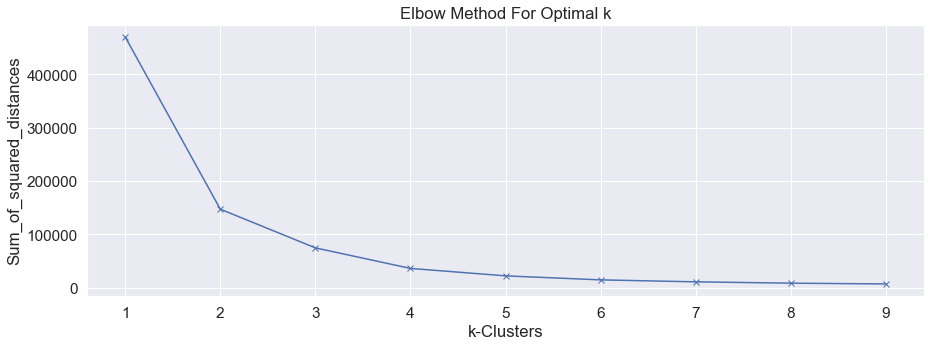

In [22]:

Sum_of_squared_distances = []
K = range(1,10)
 
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(processed_dataset[['Hour']])
    Sum_of_squared_distances.append(km.inertia_)
fig, ax = plt.subplots(figsize=(15,5)) # width & height 
plt.plot(K, Sum_of_squared_distances, 'bx-')
ax.set(xlabel='k-Clusters', ylabel='Sum_of_squared_distances', title='Elbow Method For Optimal k')
plt.show()

In [23]:
kmeans = KMeans(n_clusters=3, n_init=3, max_iter=500, random_state=54)
kmeans = kmeans.fit(processed_dataset[['Hour']])

#Save the labels
processed_dataset.loc[:,'Cluster'] = kmeans.labels_
processed_dataset.head()

,event_datetime,player_id,level_number,status,session_id,day_of_week_num,day_of_month,Hour,Minute,Seconds,...,level_number_46,level_number_47,level_number_48,day_of_week_num_0,day_of_week_num_1,day_of_week_num_2,day_of_week_num_3,day_of_week_num_4,day_of_week_num_5,Cluster
43902,2020-11-27 20:11:37.082,00001bc5552cd394a4b25b2ceb4ae7cd,1,0,3d99b46e8e892eac3b40b673140a8c23,4,27,20,11,37,...,0,0,0,0,0,0,0,1,0,0
20172,2020-11-27 20:16:13.531,00001bc5552cd394a4b25b2ceb4ae7cd,2,0,3d99b46e8e892eac3b40b673140a8c23,4,27,20,16,13,...,0,0,0,0,0,0,0,1,0,0
48633,2020-11-18 17:51:00.223,000026e096ee1c36cb88234a4dcbb42e,1,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,51,0,...,0,0,0,0,0,1,0,0,0,0
47716,2020-11-18 17:53:56.799,000026e096ee1c36cb88234a4dcbb42e,2,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,53,56,...,0,0,0,0,0,1,0,0,0,0
50674,2020-11-18 17:57:08.119,000026e096ee1c36cb88234a4dcbb42e,4,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,57,8,...,0,0,0,0,0,1,0,0,0,0


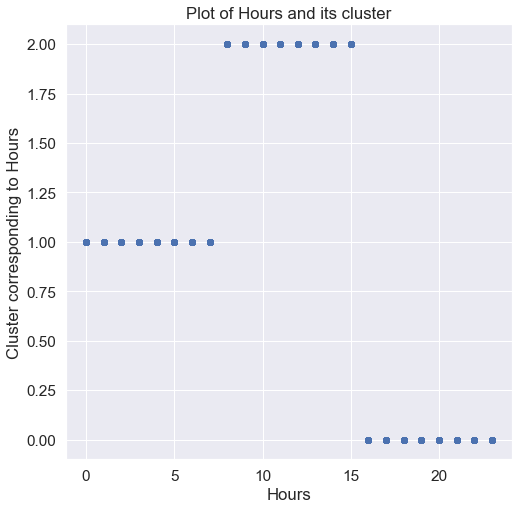

In [24]:
fig, ax = plt.subplots(figsize=(8,8)) # width & height 
ax.set(xlabel ='Hours', ylabel='Cluster corresponding to Hours', title ='Plot of Hours and its cluster')
plt.scatter(processed_dataset['Hour'], processed_dataset['Cluster'])
plt.show()

### Dummy encoding the cluster which was derived from Hours variable

In [25]:
#one hot encoding does not allow prefixing column names so using dummy encoding

label_df  = pd.DataFrame(processed_dataset["Cluster"])
dum_df = pd.get_dummies(label_df, columns=["Cluster"], prefix=["Cluster"] )
processed_dataset = processed_dataset.join(dum_df)
processed_dataset.head()


,event_datetime,player_id,level_number,status,session_id,day_of_week_num,day_of_month,Hour,Minute,Seconds,...,day_of_week_num_0,day_of_week_num_1,day_of_week_num_2,day_of_week_num_3,day_of_week_num_4,day_of_week_num_5,Cluster,Cluster_0,Cluster_1,Cluster_2
43902,2020-11-27 20:11:37.082,00001bc5552cd394a4b25b2ceb4ae7cd,1,0,3d99b46e8e892eac3b40b673140a8c23,4,27,20,11,37,...,0,0,0,0,1,0,0,1,0,0
20172,2020-11-27 20:16:13.531,00001bc5552cd394a4b25b2ceb4ae7cd,2,0,3d99b46e8e892eac3b40b673140a8c23,4,27,20,16,13,...,0,0,0,0,1,0,0,1,0,0
48633,2020-11-18 17:51:00.223,000026e096ee1c36cb88234a4dcbb42e,1,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,51,0,...,0,0,1,0,0,0,0,1,0,0
47716,2020-11-18 17:53:56.799,000026e096ee1c36cb88234a4dcbb42e,2,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,53,56,...,0,0,1,0,0,0,0,1,0,0
50674,2020-11-18 17:57:08.119,000026e096ee1c36cb88234a4dcbb42e,4,0,ec9e86c81c5ab49a30c7ac801b5c86d3,2,18,17,57,8,...,0,0,1,0,0,0,0,1,0,0


### Model-4, with only 28 levels as categorical variables with Level 3 being the reference class and Hours as a categorical variable

In [26]:
X= processed_dataset[[  'level_number_1', 'level_number_2',   'level_number_4', 'level_number_5', 'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9', 'level_number_10', 'level_number_11', 'level_number_12', 'level_number_13', 'level_number_14', 'level_number_15', 'level_number_16', 'level_number_17', 'level_number_18', 'level_number_19', 'level_number_20', 'level_number_21', 'level_number_22', 'level_number_23', 'level_number_24', 'level_number_25', 'level_number_26', 'level_number_27', 'level_number_28', 'level_number_29','Cluster_0','Cluster_2']].copy()

y= pd.DataFrame(processed_dataset["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

# Logistic regression model
logm_stratify = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm_stratify.fit(maxiter=100).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                10261
Model:                            GLM   Df Residuals:                    10230
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4224.2
Date:                Thu, 07 Jan 2021   Deviance:                       8448.4
Time:                        11:00:28   Pearson chi2:                 1.03e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.1110      0.266     -4.176      0.000      -1.632      -0.590
level_number_1     -4.2080      0.419    -10.038      0.000      -5.030      -3.386
level_number_2     -2.2285      0.288     -7.739      0.000      -2.793      -1.664
level_number_4     -0.2332      0.263     -0.887      0.375      -0.748       0.282
level_number_5      0.1540      0.262      0.587      0.557      -0.360       0.668
level_number_6      0.2027      0.265      0.765      0.444      -0.317       0.722
level_number_7     -0.0507      0.270     -0.187      0.851      -0.580       0.479
level_number_8      0.2254      0.271      0.831      0.406      -0.306       0.757
level_number_9     -0.1465      0.280     -0.523      0.601      -0.696       0.403
level_number_10    -0.2211      0.287     -0.770      0.441      -0.784       0.342
level_number_11    -0.0151      0.285     -0.053      0.958      -0.574       0.543
level_number_12     0.0895      0.290      0.308      0.758      -0.479       0.659
level_number_13     0.1877      0.291      0.644      0.519      -0.383       0.759
level_number_14     0.1634      0.294      0.555      0.579      -0.414       0.741
level_number_15    -0.2101      0.324     -0.647      0.517      -0.846       0.426
level_number_16    -0.0441      0.323     -0.137      0.891      -0.677       0.589
level_number_17     0.1424      0.326      0.437      0.662      -0.497       0.782
level_number_18    -0.2630      0.357     -0.737      0.461      -0.962       0.436
level_number_19     0.1640      0.335      0.489      0.625      -0.493       0.821
level_number_20    -0.4519      0.389     -1.162      0.245      -1.214       0.310
level_number_21    -0.4800      0.406     -1.182      0.237      -1.276       0.316
level_number_22     0.2545      0.374      0.680      0.496      -0.479       0.988
level_number_23     0.6565      0.365      1.796      0.072      -0.060       1.373
level_number_24    -1.6651      0.772     -2.156      0.031      -3.179      -0.151
level_number_25    -0.8614      0.542     -1.590      0.112      -1.923       0.201
level_number_26     0.1033      0.450      0.229      0.819      -0.779       0.986
level_number_27    -0.2671      0.524     -0.510      0.610      -1.294       0.760
level_number_28    -0.7418      0.673     -1.102      0.271      -2.061       0.578
level_number_29     0.2909      0.523      0.556      0.578      -0.735       1.317
Cluster_0           0.0940      0.091      1.035      0.301      -0.084       0.272
Cluster_2          -0.0128      0.093     -0.138      0.890      -0.195       0.169
===================================================================================
"""

### Model-5,  with 28 individual levels as categorical variables, merged level 30-48 as single variable because of less data. Level 3 remain as reference class and Hours as a Continuous variable.

In [27]:

processed_dataset = raw_data.copy()

processed_dataset = processed_dataset.loc[processed_dataset["day_of_week_num"] != 6 ]  # Remove Sunday - reference class
processed_dataset = processed_dataset.loc[processed_dataset["level_number"] !=3]  # Remove Level_number 3 - reference class
processed_dataset.loc[(processed_dataset.level_number > 29 ),'level_number']= 30  # Combine Level 30-48 as single level because of less no of observations



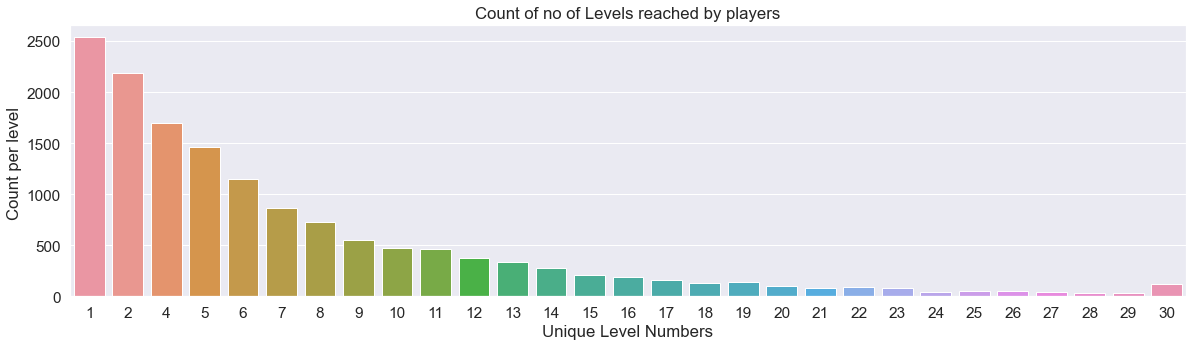

In [28]:
import seaborn as sns
plt.rcParams["figure.figsize"]=20,5
sns.set(font_scale=1.4) 

plot = sns.countplot(x="level_number", data=processed_dataset)    

plot.set(xlabel="Unique Level Numbers", ylabel = "Count per level ")
plot.set_title('Count of no of Levels reached by players')


plt.show()

In [29]:
level_number_df  = pd.DataFrame(processed_dataset["level_number"])
dum_df = pd.get_dummies(level_number_df, columns=["level_number"], prefix=["level_number"] )
processed_dataset = processed_dataset.join(dum_df)

 
day_of_week_num_df  = pd.DataFrame(processed_dataset["day_of_week_num"])
dum_df = pd.get_dummies(day_of_week_num_df, columns=["day_of_week_num"], prefix=["day_of_week_num"] )
processed_dataset = processed_dataset.join(dum_df)
processed_dataset.head()



X= processed_dataset[[  'level_number_1', 'level_number_2',   'level_number_4', 'level_number_5', 'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9', 'level_number_10', 'level_number_11', 'level_number_12', 'level_number_13', 'level_number_14', 'level_number_15', 'level_number_16', 'level_number_17', 'level_number_18', 'level_number_19', 'level_number_20', 'level_number_21', 'level_number_22', 'level_number_23', 'level_number_24', 'level_number_25', 'level_number_26', 'level_number_27', 'level_number_28', 'level_number_29','level_number_30']].copy()
X.insert(0,"hours", processed_dataset[["Hour"]])

y= pd.DataFrame(processed_dataset["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

# Logistic regression model
logm_stratify = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm_stratify.fit(maxiter=100).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                10261
Model:                            GLM   Df Residuals:                    10261
Model Family:                Binomial   Df Model:                           -1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4224.4
Date:                Thu, 07 Jan 2021   Deviance:                       8448.8
Time:                        11:01:02   Pearson chi2:                 1.03e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.4718      0.087    -16.847      0.000      -1.643      -1.301
hours               0.0088      0.005      1.813      0.070      -0.001       0.018
level_number_1     -3.9334      0.327    -12.015      0.000      -4.575      -3.292
level_number_2     -1.9525      0.143    -13.625      0.000      -2.233      -1.672
level_number_4      0.0426      0.087      0.489      0.625      -0.128       0.213
level_number_5      0.4295      0.085      5.031      0.000       0.262       0.597
level_number_6      0.4784      0.093      5.134      0.000       0.296       0.661
level_number_7      0.2247      0.106      2.117      0.034       0.017       0.433
level_number_8      0.4987      0.108      4.613      0.000       0.287       0.711
level_number_9      0.1286      0.128      1.005      0.315      -0.122       0.379
level_number_10     0.0536      0.142      0.378      0.706      -0.225       0.332
level_number_11     0.2619      0.138      1.904      0.057      -0.008       0.532
level_number_12     0.3643      0.148      2.468      0.014       0.075       0.653
level_number_13     0.4619      0.149      3.090      0.002       0.169       0.755
level_number_14     0.4379      0.155      2.821      0.005       0.134       0.742
level_number_15     0.0593      0.203      0.292      0.771      -0.339       0.458
level_number_16     0.2231      0.201      1.109      0.267      -0.171       0.617
level_number_17     0.4160      0.206      2.019      0.044       0.012       0.820
level_number_18     0.0095      0.249      0.038      0.970      -0.478       0.497
level_number_19     0.4388      0.219      2.001      0.045       0.009       0.869
level_number_20    -0.1753      0.290     -0.604      0.546      -0.744       0.393
level_number_21    -0.2090      0.312     -0.671      0.502      -0.820       0.402
level_number_22     0.5336      0.272      1.964      0.049       0.001       1.066
level_number_23     0.9349      0.260      3.591      0.000       0.425       1.445
level_number_24    -1.3893      0.707     -1.965      0.049      -2.775      -0.004
level_number_25    -0.5800      0.466     -1.245      0.213      -1.493       0.333
level_number_26     0.3873      0.364      1.065      0.287      -0.325       1.100
level_number_27     0.0077      0.446      0.017      0.986      -0.867       0.882
level_number_28    -0.4658      0.605     -0.770      0.441      -1.652       0.720
level_number_29     0.5724      0.446      1.284      0.199      -0.301       1.446
level_number_30     0.2688      0.250      1.073      0.283      -0.222       0.760
===================================================================================
"""

### Model-6,  with an additional categorical variable Day_of_week_num to model 5. Sunday is a reference variable (day_of_week_num_6).

In [30]:
X= processed_dataset[[  'level_number_1', 'level_number_2',   'level_number_4', 'level_number_5', 'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9', 'level_number_10', 'level_number_11', 'level_number_12', 'level_number_13', 'level_number_14', 'level_number_15', 'level_number_16', 'level_number_17', 'level_number_18', 'level_number_19', 'level_number_20', 'level_number_21', 'level_number_22', 'level_number_23', 'level_number_24', 'level_number_25', 'level_number_26', 'level_number_27', 'level_number_28', 'level_number_29','level_number_30','day_of_week_num_0','day_of_week_num_1','day_of_week_num_2','day_of_week_num_3','day_of_week_num_4','day_of_week_num_5']].copy()
X.insert(0,"hours", processed_dataset[["Hour"]])

y= pd.DataFrame(processed_dataset["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

In [31]:
# Logistic regression model
logm_stratify = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res= logm_stratify.fit(maxiter=100)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                10261
Model:                            GLM   Df Residuals:                    10226
Model Family:                Binomial   Df Model:                           34
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4221.8
Date:                Thu, 07 Jan 2021   Deviance:                       8443.7
Time:                        11:01:24   Pearson chi2:                 1.03e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.2687      0.076    -16.780      0.000      -1.417      -1.120
hours                 0.0089      0.005      1.827      0.068      -0.001       0.018
level_number_1       -3.9316      0.327    -12.009      0.000      -4.573      -3.290
level_number_2       -1.9506      0.143    -13.598      0.000      -2.232      -1.669
level_number_4        0.0483      0.087      0.553      0.580      -0.123       0.220
level_number_5        0.4342      0.086      5.069      0.000       0.266       0.602
level_number_6        0.4848      0.093      5.187      0.000       0.302       0.668
level_number_7        0.2264      0.106      2.128      0.033       0.018       0.435
level_number_8        0.5014      0.108      4.627      0.000       0.289       0.714
level_number_9        0.1325      0.128      1.034      0.301      -0.119       0.383
level_number_10       0.0561      0.142      0.395      0.693      -0.223       0.335
level_number_11       0.2642      0.138      1.918      0.055      -0.006       0.534
level_number_12       0.3667      0.148      2.482      0.013       0.077       0.656
level_number_13       0.4593      0.150      3.069      0.002       0.166       0.753
level_number_14       0.4317      0.155      2.777      0.005       0.127       0.736
level_number_15       0.0559      0.204      0.274      0.784      -0.343       0.455
level_number_16       0.2216      0.201      1.101      0.271      -0.173       0.616
level_number_17       0.4043      0.207      1.958      0.050      -0.000       0.809
level_number_18       0.0032      0.249      0.013      0.990      -0.485       0.491
level_number_19       0.4398      0.219      2.005      0.045       0.010       0.870
level_number_20      -0.1779      0.290     -0.613      0.540      -0.747       0.391
level_number_21      -0.2006      0.312     -0.643      0.520      -0.812       0.410
level_number_22       0.5527      0.272      2.033      0.042       0.020       1.086
level_number_23       0.9606      0.261      3.686      0.000       0.450       1.471
level_number_24      -1.3799      0.707     -1.952      0.051      -2.766       0.006
level_number_25      -0.5586      0.466     -1.198      0.231      -1.472       0.355
level_number_26       0.4024      0.364      1.106      0.269      -0.311       1.116
level_number_27       0.0301      0.446      0.067      0.946      -0.845       0.905
level_number_28      -0.4384      0.605     -0.724      0.469      -1.625       0.748
level_number_29       0.6017      0.446      1.349      0.177      -0.273       1.476
level_number_30       0.2908      0.251      1.159      0.246      -0.201       0.782
day_of_week_num_0    -0.1818      0.058     -3.108      0.002      -0.296      -0.067
day_of_week_num_1    -0.2313      0.061     -3.783      0.000      -0.351

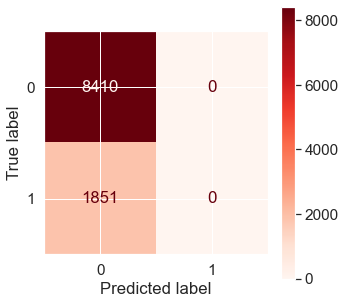

In [33]:
y_train_pred = res.predict( sm.add_constant(X_train))
y_train_pred[:10]

# Creating a dataframe with the actual status  and the predicted probabilities
y_train_pred_final = pd.DataFrame({'status':y_train.iloc[:,0], 'status_Prob':y_train_pred})
y_train_pred_final['PlayerID'] = y_train.index
 
# Creating new column 'predicted' with 1 if status_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.status_Prob.map(lambda x: 1 if x > 0.5 else 0)



plt.rcParams["figure.figsize"]=5,5
cm = confusion_matrix(y_train, y_train_pred_final['predicted'], labels=np.array([0,1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0,1]))
disp.plot(colorbar=True,cmap=plt.cm.Reds) 


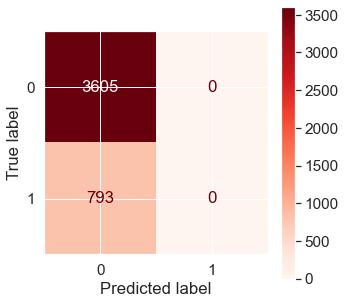

In [34]:
y_test_pred = res.predict( sm.add_constant(X_test))
y_test_pred[:10]

# Creating a dataframe with the actual status  and the predicted probabilities
y_test_pred_final = pd.DataFrame({'status':y_test.iloc[:,0], 'status_Prob':y_test_pred})
y_test_pred_final['PlayerID'] = y_test.index
# y_train_pred_final.head()
# Creating new column 'predicted' with 1 if status_Prob > 0.5 else 0
y_test_pred_final['predicted'] = y_test_pred_final.status_Prob.map(lambda x: 1 if x > 0.5 else 0)


plt.rcParams["figure.figsize"]=5,5
cm = confusion_matrix(y_test, y_test_pred_final['predicted'], labels=np.array([0,1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0,1]))
disp.plot(colorbar=True,cmap=plt.cm.Reds) 

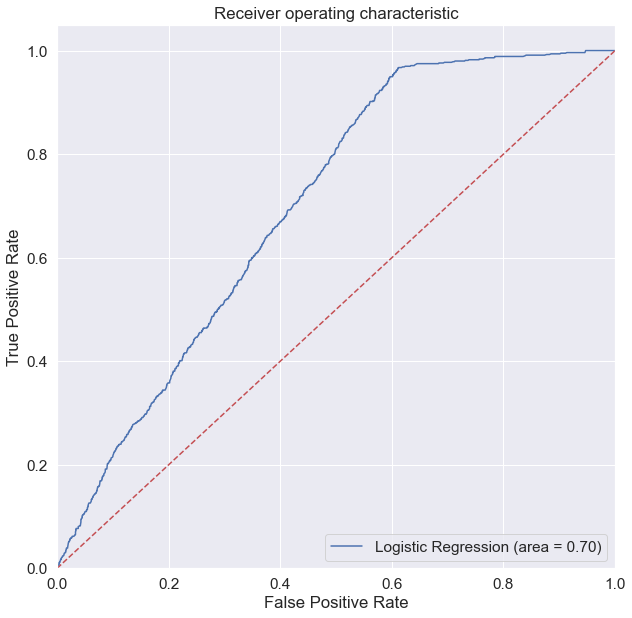

In [35]:

X_test = sm.add_constant(X_test)
logit_roc_auc = roc_auc_score(y_test, res.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, res.predict(X_test))
plt.rcParams["figure.figsize"]=10,10
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

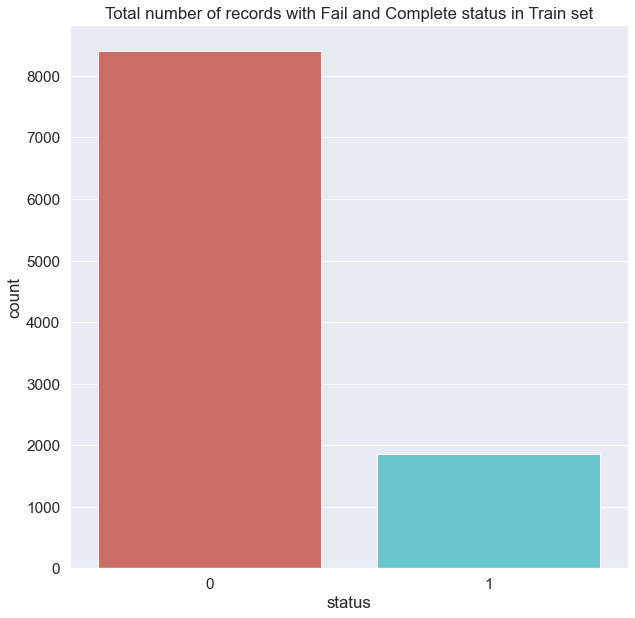

In [36]:
plot = sns.countplot(x='status',data=y_train, palette='hls')
plot.set_title('Total number of records with Fail and Complete status in Train set')
# plot.set(xlabel="Unique Level Numbers", ylabel = "Count per level ")


plt.show()


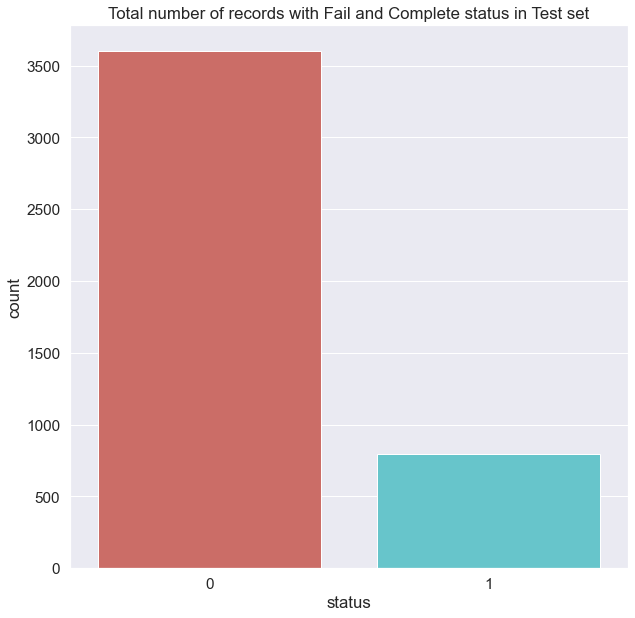

In [37]:
 
plot = sns.countplot(x='status',data=y_test, palette='hls')
plot.set_title('Total number of records with Fail and Complete status in Test set')
# plot.set(xlabel="Unique Level Numbers", ylabel = "Count per level ")


plt.show()


In [38]:
y_train_pred_final.describe()

,status,status_Prob,PlayerID,predicted
count,10261.000000,10261.000000,10261.000000,10261.0
mean,0.180392,0.180392,27973.322386,0.0
std,0.384532,0.116963,16211.326565,0.0
min,0.000000,0.004003,12.000000,0.0
25%,0.000000,0.036178,13864.000000,0.0
50%,0.000000,0.224149,27913.000000,0.0
75%,0.000000,0.278749,42173.000000,0.0
max,1.000000,0.428117,55817.000000,0.0


### SMOTE  to increase the data of the failure status which can solve the class imbalance problem

#### 1. SMOTENC- which handles both categorical variable (level numbers, Day_of_week_num) and numeric variables (hours)

In [39]:
print('Original dataset shape (%s, %s)' % X.shape)
print('Original dataset samples per class {}'.format(Counter(y)))

S_NC = SMOTENC(random_state=42, categorical_features=list(range(1,29)))
X_res, y_res = S_NC.fit_resample(X, y)
print('Resampled dataset samples per class {}'.format(Counter(y_res)))

Original dataset shape (14659, 36)
Original dataset samples per class Counter({'status': 1})
Resampled dataset samples per class Counter({'status': 1})


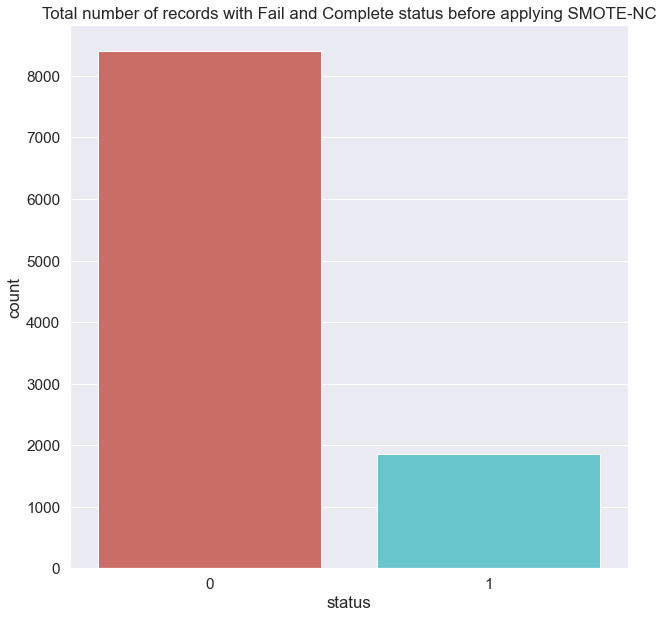

In [40]:
X_train1= X_train.copy()
X_train1.insert(0,"status",y_train[['status']])
plot = sns.countplot(x='status',data=X_train1, palette='hls')
plot.set_title('Total number of records with Fail and Complete status before applying SMOTE-NC')
 
plt.show()

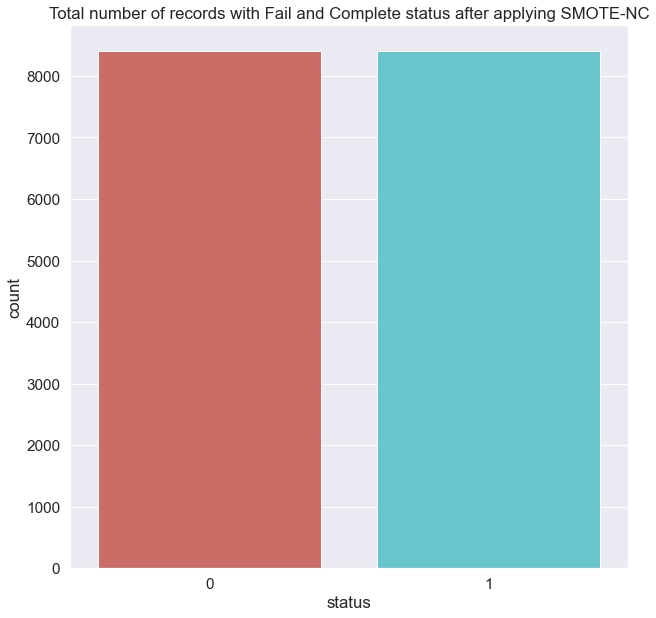

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.7, test_size=0.3, random_state=100,stratify=y_res)
X_train1= X_train.copy()
X_train1.insert(0,"status",y_train[['status']])
plot = sns.countplot(x='status',data=X_train1, palette='hls')
plot.set_title('Total number of records with Fail and Complete status after applying SMOTE-NC')
plt.show()

### Model-7, Using SMOTENC technique to increase no of records for FAIL status across all levels, different hours of play and Day of play in a week

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.7, test_size=0.3, random_state=100,stratify=y_res)


# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                16821
Model:                            GLM   Df Residuals:                    16821
Model Family:                Binomial   Df Model:                           -1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6893.2
Date:                Thu, 07 Jan 2021   Deviance:                       13786.
Time:                        11:04:13   Pearson chi2:                 1.71e+04
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                29.9692   1.25e+04      0.002      0.998   -2.46e+04    2.46e+04
hours                 0.0206      0.004      5.383      0.000       0.013       0.028
level_number_1      -12.9294      1.031    -12.537      0.000     -14.951     -10.908
level_number_2      -11.5927      1.010    -11.474      0.000     -13.573      -9.613
level_number_4       -8.1639      1.001     -8.154      0.000     -10.126      -6.202
level_number_5       -7.7111      1.001     -7.701      0.000      -9.674      -5.749
level_number_6       -7.8544      1.002     -7.841      0.000      -9.818      -5.891
level_number_7       -8.5729      1.003     -8.549      0.000     -10.538      -6.607
level_number_8       -8.1911      1.003     -8.167      0.000     -10.157      -6.225
level_number_9       -9.0742      1.006     -9.023      0.000     -11.045      -7.103
level_number_10      -8.8407      1.006     -8.790      0.000     -10.812      -6.869
level_number_11      -8.5772      1.006     -8.529      0.000     -10.548      -6.606
level_number_12      -9.0350      1.009     -8.953      0.000     -11.013      -7.057
level_number_13      -8.3255      1.007     -8.271      0.000     -10.299      -6.353
level_number_14      -8.6453      1.008     -8.573      0.000     -10.622      -6.669
level_number_15      -9.0740      1.015     -8.941      0.000     -11.063      -7.085
level_number_16      -8.9318      1.015     -8.801      0.000     -10.921      -6.943
level_number_17      -8.3632      1.014     -8.251      0.000     -10.350      -6.377
level_number_18      -9.2656      1.025     -9.040      0.000     -11.275      -7.257
level_number_19      -9.2585      1.027     -9.015      0.000     -11.271      -7.246
level_number_20      -9.8348      1.046     -9.407      0.000     -11.884      -7.786
level_number_21      -9.6223      1.047     -9.191      0.000     -11.674      -7.570
level_number_22      -8.6393      1.029     -8.394      0.000     -10.657      -6.622
level_number_23      -8.7675      1.039     -8.438      0.000     -10.804      -6.731
level_number_24      -9.8410      1.095     -8.983      0.000     -11.988      -7.694
level_number_25      -9.9754      1.111     -8.977      0.000     -12.153      -7.798
level_number_26      -9.2745      1.066     -8.701      0.000     -11.364      -7.185
level_number_27      -9.4441      1.103     -8.564      0.000     -11.605      -7.283
level_number_28     -10.5324      1.246     -8.454      0.000     -12.974      -8.091
level_number_29      -8.9311      1.101     -8.114      0.000     -11.088      -6.774
level_number_30      -8.2103      1.017     -8.072      0.000     -10.204      -6.217
day_of_week_num_0   -21.9999   1.25e+04     -0.002      0.999   -2.46e+04    2.46e+04
day_of_week_num_1   -22.0732   1.25e+04     -0.002      0.999   -2.46e+04

#### 2. BorderlineSMOTE which is an ADAPTIVE SMOTE technique for only Continuous variable (Level_number, Hours) to avoid overfitting

In [43]:
processed_dataset = raw_data.copy()

processed_dataset= processed_dataset.drop([  "event_datetime","player_id","session_id","day_of_month","Seconds","Minute"],axis=1)

In [44]:
processed_dataset.columns

Index(['level_number', 'status', 'day_of_week_num', 'Hour'], dtype='object')

In [45]:
from imblearn.over_sampling import BorderlineSMOTE
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(processed_dataset.drop(["status"],axis=1),processed_dataset["status"])
y=pd.DataFrame(y)
print('Original dataset shape  ' , processed_dataset.drop(["status"],axis=1).shape)
print('SMOTE applied dataset shape ', X.shape)

Original dataset shape   (20944, 3)
SMOTE applied dataset shape  (33670, 3)


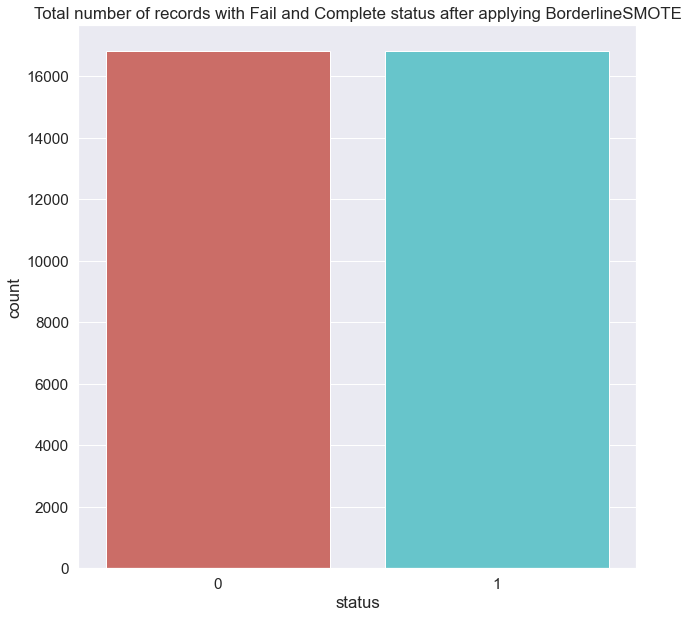

In [46]:
X_train1= X.copy()
X_train1.insert(0,"status",y[['status']])
plot = sns.countplot(x='status',data=X_train1, palette='hls')
plot.set_title('Total number of records with Fail and Complete status after applying BorderlineSMOTE')
plt.show()

In [47]:
del(processed_dataset)


X.insert(0,"status", y[["status"]])
processed_dataset = X.copy()
processed_dataset = processed_dataset.loc[processed_dataset["day_of_week_num"] != 6 ]  # Remove Sunday - reference class
processed_dataset = processed_dataset.loc[processed_dataset["level_number"] !=3]  # Remove Level_number 3 - reference class
processed_dataset.loc[(processed_dataset.level_number > 29 ),'level_number']= 30  # Combine Level 30-48 as single level because of less no of observations

In [48]:
level_number_df  = pd.DataFrame(processed_dataset["level_number"])
dum_df = pd.get_dummies(level_number_df, columns=["level_number"], prefix=["level_number"] )
processed_dataset = processed_dataset.join(dum_df)


day_of_week_num_df  = pd.DataFrame(processed_dataset["day_of_week_num"])
dum_df = pd.get_dummies(day_of_week_num_df, columns=["day_of_week_num"], prefix=["day_of_week_num"] )
processed_dataset = processed_dataset.join(dum_df)


### Model-8, Using Borderline SMOTE (an adaptive SMOTE technique which avoids overfitting) technique to increase no of records for FAIL status across all levels

In [49]:
X= processed_dataset[[  'level_number_1', 'level_number_2',   'level_number_4', 'level_number_5', 'level_number_6', 'level_number_7', 'level_number_8', 'level_number_9', 'level_number_10', 'level_number_11', 'level_number_12', 'level_number_13', 'level_number_14', 'level_number_15', 'level_number_16', 'level_number_17', 'level_number_18', 'level_number_19', 'level_number_20', 'level_number_21', 'level_number_22', 'level_number_23', 'level_number_24', 'level_number_25', 'level_number_26', 'level_number_27', 'level_number_28', 'level_number_29','level_number_30','day_of_week_num_0','day_of_week_num_1','day_of_week_num_2','day_of_week_num_3','day_of_week_num_4','day_of_week_num_5']].copy()
X.insert(0,"hours", processed_dataset[["Hour"]])

y= pd.DataFrame(processed_dataset["status"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100,stratify=y)

# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res= logm1.fit(maxiter=5000)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                16042
Model:                            GLM   Df Residuals:                    16042
Model Family:                Binomial   Df Model:                           -1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9117.4
Date:                Thu, 07 Jan 2021   Deviance:                       18235.
Time:                        11:04:38   Pearson chi2:                 1.60e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0349      0.048     -0.724      0.469      -0.129       0.060
hours                 0.0026      0.003      0.803      0.422      -0.004       0.009
level_number_1       -3.7644      0.156    -24.116      0.000      -4.070      -3.458
level_number_2       -2.2837      0.089    -25.779      0.000      -2.457      -2.110
level_number_4        0.1583      0.054      2.927      0.003       0.052       0.264
level_number_5        0.6790      0.054     12.495      0.000       0.573       0.786
level_number_6        0.4324      0.062      6.930      0.000       0.310       0.555
level_number_7        0.1376      0.070      1.965      0.049       0.000       0.275
level_number_8        0.5723      0.072      7.938      0.000       0.431       0.714
level_number_9        0.1251      0.083      1.514      0.130      -0.037       0.287
level_number_10       0.0214      0.092      0.233      0.816      -0.159       0.202
level_number_11       0.4703      0.087      5.382      0.000       0.299       0.642
level_number_12       0.4157      0.098      4.240      0.000       0.224       0.608
level_number_13       0.7233      0.097      7.430      0.000       0.533       0.914
level_number_14       0.3378      0.107      3.158      0.002       0.128       0.547
level_number_15       0.1561      0.128      1.218      0.223      -0.095       0.407
level_number_16       0.3248      0.130      2.495      0.013       0.070       0.580
level_number_17       0.2154      0.146      1.480      0.139      -0.070       0.501
level_number_18      -0.1884      0.168     -1.122      0.262      -0.518       0.141
level_number_19       0.4289      0.150      2.866      0.004       0.136       0.722
level_number_20      -0.4993      0.199     -2.507      0.012      -0.890      -0.109
level_number_21      -0.0614      0.187     -0.328      0.743      -0.429       0.306
level_number_22       0.7848      0.182      4.319      0.000       0.429       1.141
level_number_23       0.9004      0.194      4.646      0.000       0.521       1.280
level_number_24      -0.7379      0.306     -2.412      0.016      -1.337      -0.138
level_number_25      -0.7300      0.295     -2.474      0.013      -1.308      -0.152
level_number_26       0.3601      0.250      1.442      0.149      -0.129       0.849
level_number_27      -0.1400      0.297     -0.471      0.638      -0.723       0.443
level_number_28       0.0405      0.320      0.127      0.899      -0.586       0.667
level_number_29       0.6615      0.311      2.125      0.034       0.051       1.272
level_number_30       0.4247      0.163      2.608      0.009       0.105       0.744
day_of_week_num_0     0.0494      0.038      1.287      0.198      -0.026       0.125
day_of_week_num_1    -0.0053      0.040     -0.133      0.894      -0.084

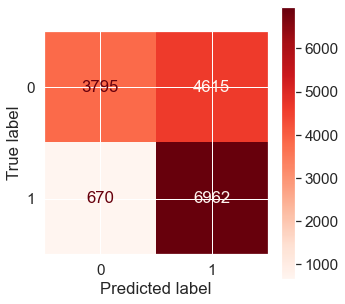

In [50]:
y_train_pred = res.predict( sm.add_constant(X_train))


# Creating a dataframe with the actual status  and the predicted probabilities
y_train_pred_final = pd.DataFrame({'status':y_train.iloc[:,0], 'status_Prob':y_train_pred})
y_train_pred_final['PlayerID'] = y_train.index
 
# Creating new column 'predicted' with 1 if status_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.status_Prob.map(lambda x: 1 if x > 0.5 else 0)


plt.rcParams["figure.figsize"]=5,5
cm = confusion_matrix(y_train, y_train_pred_final['predicted'], labels=np.array([0,1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0,1]))
disp.plot(colorbar=True,cmap=plt.cm.Reds) 


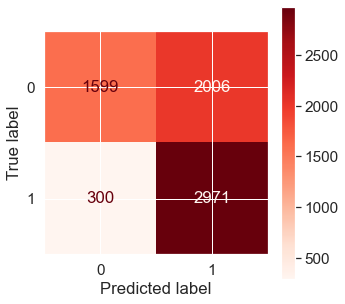

In [51]:
y_test_pred = res.predict( sm.add_constant(X_test))
y_test_pred[:10]

# Creating a dataframe with the actual status  and the predicted probabilities
y_test_pred_final = pd.DataFrame({'status':y_test.iloc[:,0], 'status_Prob':y_test_pred})
y_test_pred_final['PlayerID'] = y_test.index
# y_train_pred_final.head()
# Creating new column 'predicted' with 1 if status_Prob > 0.5 else 0
y_test_pred_final['predicted'] = y_test_pred_final.status_Prob.map(lambda x: 1 if x > 0.5 else 0)


plt.rcParams["figure.figsize"]=5,5
cm = confusion_matrix(y_test, y_test_pred_final['predicted'], labels=np.array([0,1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0,1]))
disp.plot(colorbar=True,cmap=plt.cm.Reds) 


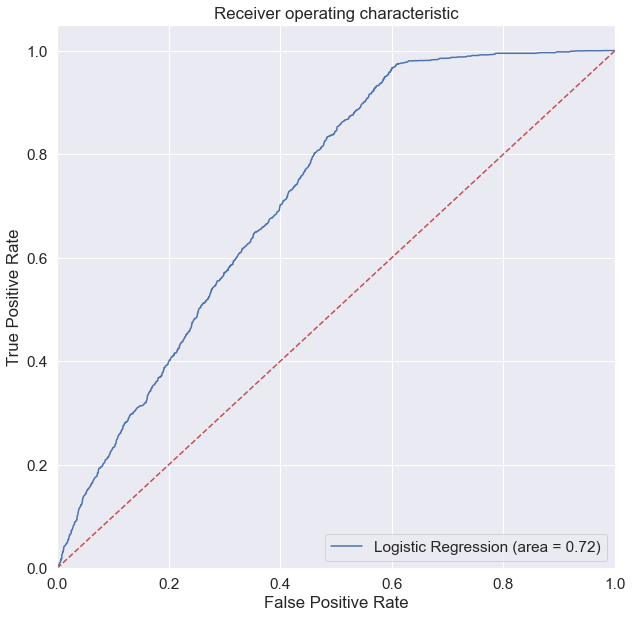

In [52]:


X_test = sm.add_constant(X_test)
logit_roc_auc = roc_auc_score(y_test, res.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, res.predict(X_test))
plt.rcParams["figure.figsize"]=10,10
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

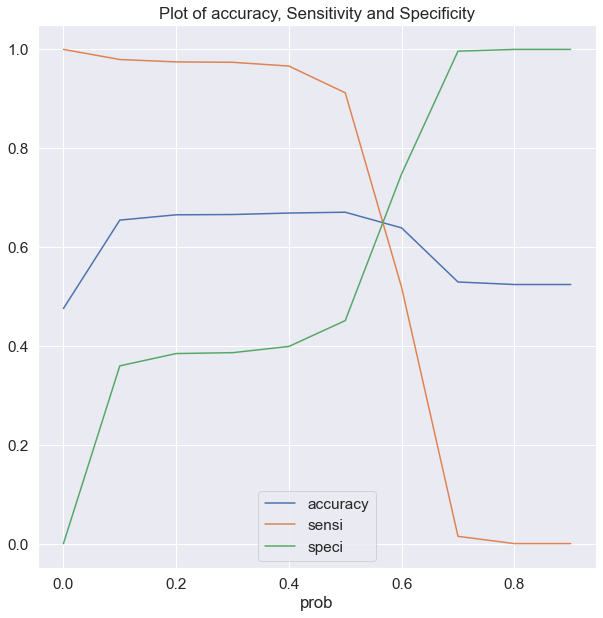

In [53]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.status_Prob.map(lambda x: 1 if x > i else 0)


# Calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

 
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.status, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]


# Ploting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.title('Plot of accuracy, Sensitivity and Specificity')
plt.show()